# NYC Travel Dataset

In [1]:
# Initialize Notebook with mylib.py
%run mylib.py

## Dataset content

This dataset is made of 11 columns, which contains 10 independent variables and one dependent.
The 10 independent variables will be the features from Travel dataset, and the dependent one will be the result: *trip_duration*

Here is a description of the variables.

### Independent variables

* id - a unique identifier for each trip.
* vendorid - a code indicating the provider associated with the trip record.
* pickupdatetime - date and time when the meter was engaged.
* dropoffdatetime - date and time when the meter was disengaged.
* passengercount - the number of passengers in the vehicle (driver entered value).
* pickuplongitude - the longitude where the meter was engaged
* pickuplatitude - the latitude where the meter was engaged
* dropofflongitude - the longitude where the meter was disengaged
* dropofflatitude - the latitude where the meter was disengaged
* store_and_fwd_flag — This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server — Y=store and forward; N=not a store and forward trip.

### Dependent variable

* trip_duration — duration of the trip in seconds.

It's now time to load the dataset into a Pandas dataframe.
We load data using *load_csv* function from *mylib.py*


In [2]:
# Load dataset
nyc_travel = load_csv('travel')

In [3]:
# Display first 5 lines
nyc_travel.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
# Display informations
nyc_travel.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Ok, this dataset is as claimed in the description, seems to have no missing values. That's good.
It is made of around 1'500'000 lines with three columns made of int64 values, four columns of float64 values and the rest is made of strings.

In [5]:
# Verify that we do not have missing values
nyc_travel.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

## Dataset cleaning process

As everything might not be useable to build my model, let's make some cleanup and reformating of this dataset.

First, the *id* column should be dropped from the dataset. It contains a unique id of the trip recorded, completly useless to train a model.

In [6]:
nyc_travel.drop('id', axis=1, inplace=True)

Then, let's have a look at numerical columns.

In [55]:
nyc_travel.describe().astype('int')

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1456327,1456327,1456327,1456327,1456327,1456327
mean,1,-73,40,-73,40,836
std,1,0,0,0,0,654
min,1,-121,34,-121,32,1
25%,1,-73,40,-73,40,397
50%,1,-73,40,-73,40,661
75%,2,-73,40,-73,40,1073
max,6,-61,51,-61,43,7191




What I'll do here is to use the *select_dtypes* method to get columns name containing numerical values.

For each of them, I'll draw some histogram graphs to see the distributions of the values.


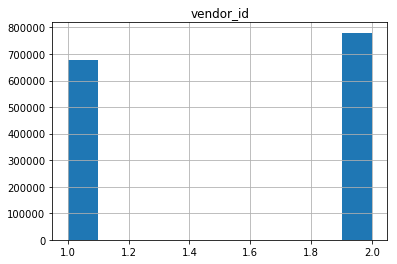

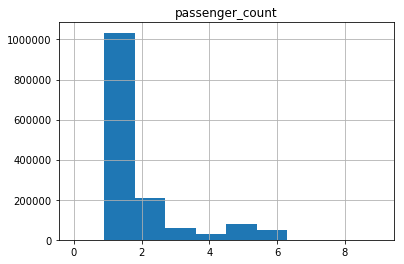

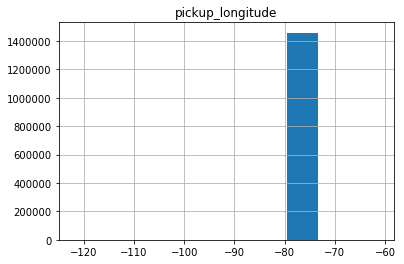

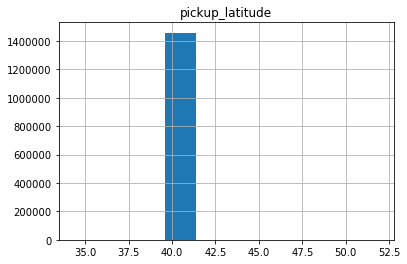

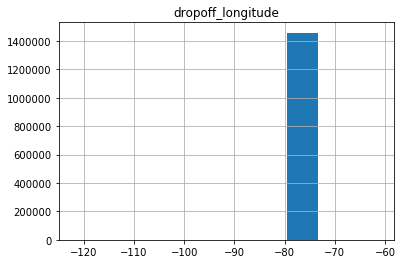

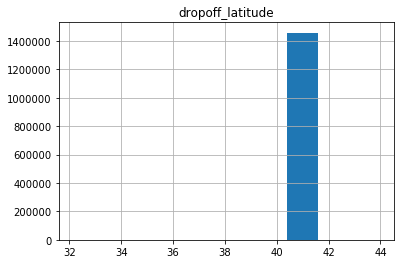

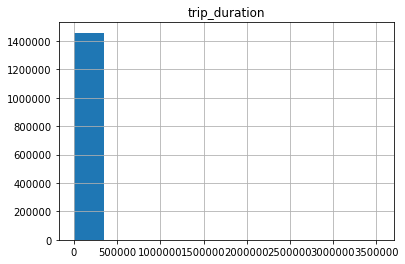

In [7]:
TRAVEL_NUMERICAL = nyc_travel.select_dtypes(include=[np.number]).columns

for i in TRAVEL_NUMERICAL:
    plt.title(i)
    nyc_travel[i].hist()
    plt.show()

### vendor_id

This column identifies the *vendor* of the trip but, looking at it's content, we can see that the number of different vendors is two, and the number of trips seems to be equally distributed.

According to this, dropping this column seems to be an evidence.

In [8]:
# Get the number of unique values
nyc_travel['vendor_id'].nunique()
nyc_travel.drop('vendor_id', axis=1, inplace=True)

### trip_duration

The histogram of this columns reveal some outliers. I do not know if those values are correct, but I decide to remove them from my dataset.

Taking an arbitrary value of 7200 seconds (2 hours) as the limit, I found 2253 lines that should be considered as outliers. I remove them.

In [9]:
# Get the number of lines concerned by a travel time above 7200 seconds
nyc_travel[nyc_travel['trip_duration'] > 7200]['trip_duration'].count()

2253

In [10]:
# Drop lines that contains travel_time > 7200
nyc_travel=nyc_travel[nyc_travel['trip_duration'] < 7200]

### passenger_count

Passenger count is a column that specifies, for a particular trip, the number of person the TAXI has taken in its car.

I've found 64 trips concerning either 0 or more than 6 passengers. For that reason, I've decided to drop those 64 lines which I consider as outliers.

In [11]:
# Count passenger_count outliers (0 or more than 6)
nyc_travel[
    np.logical_or(
        nyc_travel['passenger_count'] == 0,
        nyc_travel['passenger_count'] > 6
    )
]['passenger_count'].count()

64

In [12]:
nyc_travel = nyc_travel[
    np.logical_not(
        np.logical_or(
            nyc_travel['passenger_count'] == 0,
            nyc_travel['passenger_count'] > 6
        )
    )
]

### Longitude and latitude

Same approach for the latitude and the longitude values, we should seek for outliers and removed them.

This histogram clearly shows that some of the values are completly out of scope.

Remember, the model we would like to solve concerns *New-York City*

<Figure size 1800x1800 with 0 Axes>

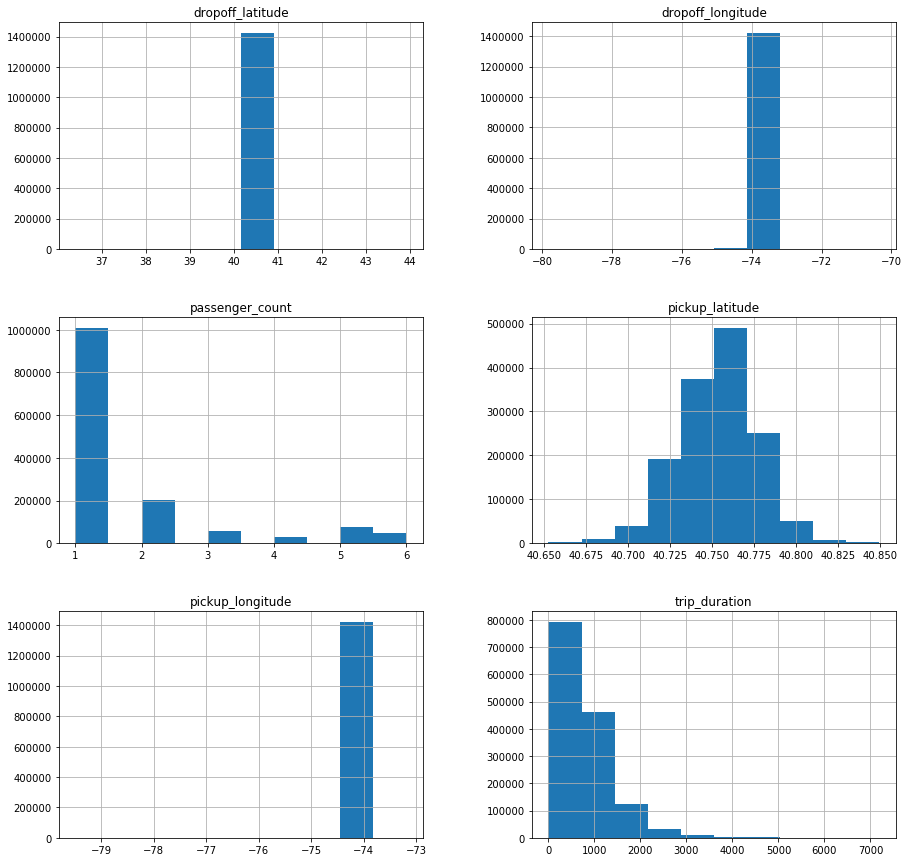

In [51]:
pick_lat_filter=np.abs((nyc_travel['pickup_latitude'] - nyc_travel['pickup_latitude'].mean())) > 3 * nyc_travel['pickup_latitude'].std()

#pick_lat_filter=np.logical_not(filter)

#plt.figure(figsize=(25,25))
#nyc_travel[filter].hist(figsize=(15,15))
#plt.show()

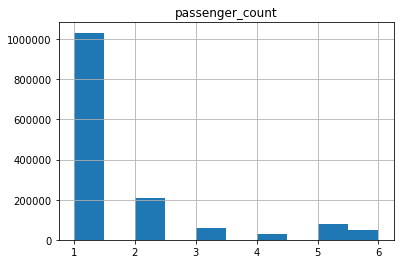

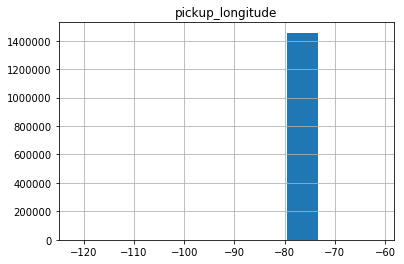

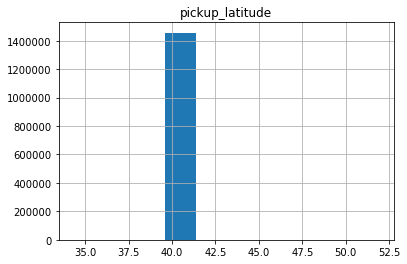

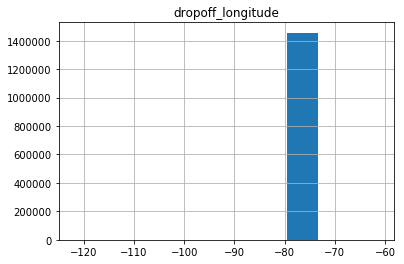

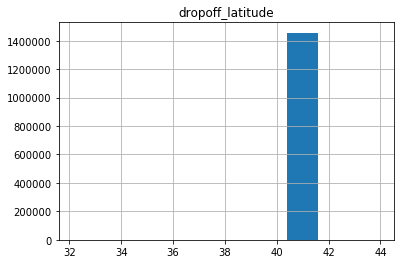

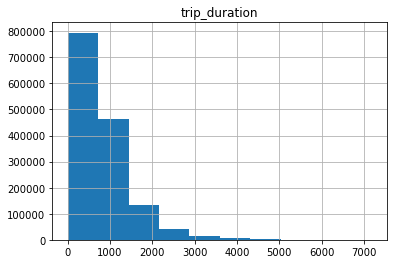

In [14]:
TRAVEL_NUMERICAL = nyc_travel.select_dtypes(include=[np.number]).columns
for i in TRAVEL_NUMERICAL:
    plt.title(i)
    nyc_travel[i].hist()
    plt.show()

In [15]:
nyc_travel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456327 entries, 0 to 1458643
Data columns (total 9 columns):
pickup_datetime       1456327 non-null object
dropoff_datetime      1456327 non-null object
passenger_count       1456327 non-null int64
pickup_longitude      1456327 non-null float64
pickup_latitude       1456327 non-null float64
dropoff_longitude     1456327 non-null float64
dropoff_latitude      1456327 non-null float64
store_and_fwd_flag    1456327 non-null object
trip_duration         1456327 non-null int64
dtypes: float64(4), int64(2), object(3)
memory usage: 111.1+ MB
